# MammoDetect: Breast Cancer Detection Using Convolutional Neural Networks (CNN)


### Summary of the CBIS-DDSM Dataset Description:

The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:

* `Number of Studies:` 6,775
* `Number of Series:` 6,775
* `Number of Participants:` 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
* `Number of Images:` 10,239
* `Modality:` MG (Mammography)
* `Image Size:` 6 GB in JPEG format



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\khale\.cache\kagglehub\datasets\awsaf49\cbis-ddsm-breast-cancer-image-dataset\versions\1


### Import needed libraries


In [85]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import RandomRotation, RandomAffine, RandomHorizontalFlip, Resize, ToTensor, Normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.optim.lr_scheduler import ReduceLROnPlateau



random.seed(100)

### Loading Image


In [ ]:
dicom_data = pd.read_csv(f'{path}/csv/dicom_info.csv')
image_dir = f'{path}/jpeg'

In [4]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [5]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

### Preprocessing & Displaying different types of images

In [ ]:
cropped_images = dicom_data.loc[dicom_data.SeriesDescription == 'cropped images', 'image_path']
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [ ]:
# Replace the path to the images
cropped_images = cropped_images.str.replace('CBIS-DDSM/jpeg', image_dir)
cropped_images.head()

0     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
3     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
6     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
7     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
10    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

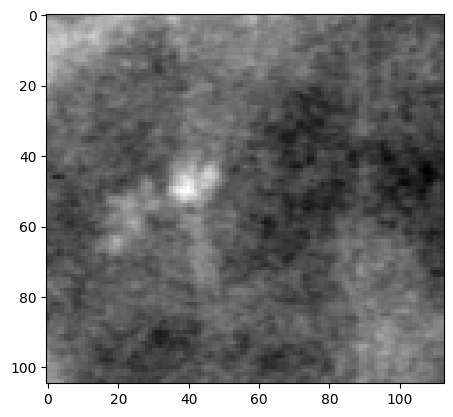

In [ ]:
# Display the images
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [9]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
2     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
11    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
12    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
15    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

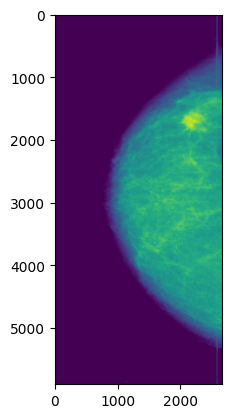

In [ ]:
for file in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [12]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [13]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
8     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
9     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
14    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
20    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

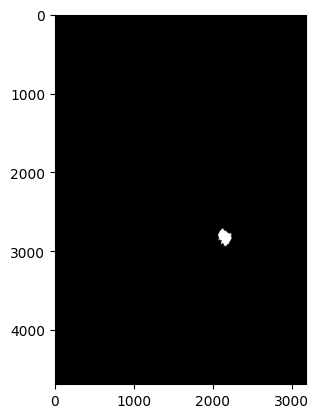

In [14]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

---

In [15]:
calc_case_df = pd.read_csv(f'{path}/csv/calc_case_description_train_set.csv')

In [16]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [17]:
mass_case_df = pd.read_csv(f'{path}/csv/mass_case_description_train_set.csv')

In [18]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


### Data Cleaning

In [19]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [20]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

In [21]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [22]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [23]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

C:\Users\khale\AppData\Local\Temp\ipykernel_25932\3809955931.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\3809955931.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


In [24]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

C:\Users\khale\AppData\Local\Temp\ipykernel_25932\3223890453.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\3223890453.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


In [25]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [26]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = calc_case_df.rename(columns={
    'calc type': 'calc_type', 'calc distribution': 'calc_distribution', 'image view': 'image_view',
    'left or right breast': 'left_or_right_breast', 'breast density': 'breast_density',
    'abnormality type': 'abnormality_type'
})
Data_cleaning_1 = Data_cleaning_1.astype({
    'pathology': 'category', 'calc_type': 'category', 'calc_distribution': 'category',
    'abnormality_type': 'category', 'image_view': 'category', 'left_or_right_breast': 'category'
})
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [27]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

C:\Users\khale\AppData\Local\Temp\ipykernel_25932\2703319416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\2703319416.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\2703319416.

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [28]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = mass_case_df.rename(columns={
    'mass shape': 'mass_shape', 'left or right breast': 'left_or_right_breast',
    'mass margins': 'mass_margins', 'image view': 'image_view', 'abnormality type': 'abnormality_type'
})
Data_cleaning_2 = Data_cleaning_2.astype({
    'left_or_right_breast': 'category', 'image_view': 'category', 'mass_margins': 'category',
    'mass_shape': 'category', 'abnormality_type': 'category', 'pathology': 'category'
})
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [29]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

C:\Users\khale\AppData\Local\Temp\ipykernel_25932\73198642.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\73198642.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\khale\AppData\Local\Temp\ipykernel_25932\73198642.py:2

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

---

### Data Visualization

In [30]:
# Download latest version
breast_path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", breast_path)

Path to dataset files: C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1


In [31]:
breast_imgs = glob.glob(f'{breast_path}/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [32]:
for imgname in breast_imgs[:5]:
    print(imgname)

C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


In [33]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [34]:
non_cancer_num, cancer_num = len(non_cancer_imgs), len(cancer_imgs)
total_img_num = non_cancer_num + cancer_num

print(f'Number of Images of no cancer: {non_cancer_num}')
print(f'Number of Images of cancer: {cancer_num}')
print(f'Total Number of Images: {total_img_num}')

Number of Images of no cancer: 198738
Number of Images of cancer: 78786
Total Number of Images: 277524


In [35]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [36]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

In [37]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [38]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()


from cbis-ddsm-breast-cancer-image-dataset : This study depends on Three types of images ; `cropped images` , `ROI images` , `Full mammogram images` . from this graph we conclude that `cropped images` is the most used between them

In [39]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [40]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()

**The Most Part Examined is Breast "All" = left and also right**

In [41]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [42]:
bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

from this graph: 
There are two abnormalities of breast cancer:
- Calcification abnormality
- Mass abnormality 

**Most cases are with calcification abnormalities**

In [43]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [44]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [45]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

**For calcification cancer, most cases are usually in the left breast.**

In [46]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


**Calcification cancer has 45 types, the majority of which are PLEOMORPHIC.**

#### Setup Transformers

In [47]:
transform = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization for RGB channels
])

#### Creating Custom Class

In [48]:
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = PIL.Image.open(img_path).convert("RGB")  # Retain RGB channels
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
# Create labeled lists for dataset
image_paths = non_cancer_imgs + cancer_imgs
labels = [0] * non_cancer_num + [1] * cancer_num  # 0 for non-cancer, 1 for cancer


dataset = BreastCancerDataset(image_paths, labels, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

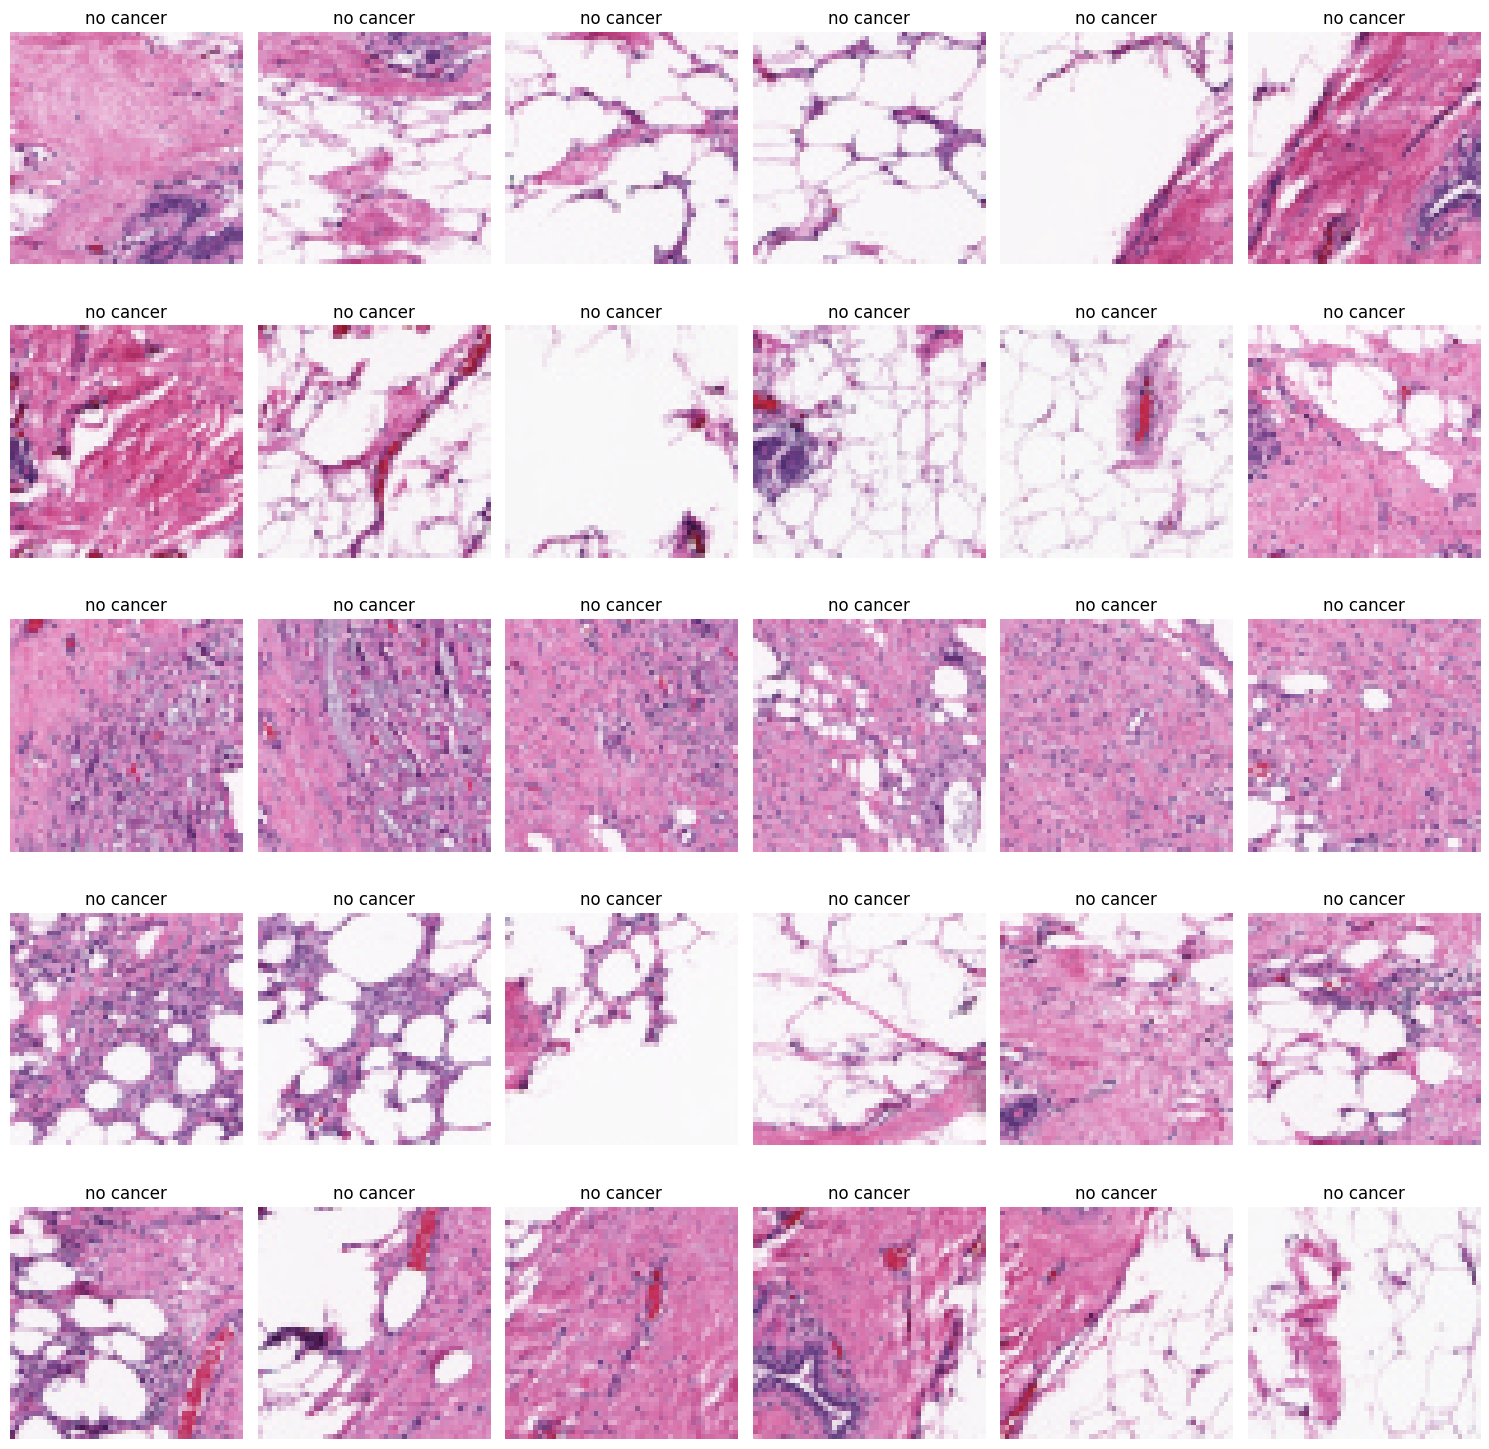

In [ ]:
# Plot a few sample images
fig, axs = plt.subplots(5, 6, figsize=(15, 15))
axs = axs.ravel()

for i in range(30):  
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Re-scale image for display
    axs[i].imshow(img)
    axs[i].set_title('cancer' if label == 1 else 'no cancer')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Data Modeling

### Data Preparation


In [51]:
# Randomly sample and shuffle images if needed
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

# Combine non-cancer and cancer images with labels (0 for non-cancer, 1 for cancer)
image_paths = some_non_img + some_can_img
labels = [0] * len(some_non_img) + [1] * len(some_can_img)

dataset = BreastCancerDataset(image_paths, labels, transform=transform)    


### Data Splitting and Subsampling

In [52]:
rate = 0.5
test_size = 0.2 
dataset_size = len(dataset)

test_len = int(dataset_size * test_size)
train_len = dataset_size - test_len

# Split and subsample the training set
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

subsample_train_len = int(len(train_dataset) * rate)
train_dataset, _ = random_split(train_dataset, [subsample_train_len, len(train_dataset) - subsample_train_len])

# Create DataLoader for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



### Data augmentation

In [53]:
# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    RandomRotation(20),
    RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


### Model Archeticture:

In [54]:
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)  # 2 classes for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel()
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


### Training and Evaluation Loop

In [ ]:
import json

# Set TRAINING flag to True if training , False if not
TRAINING = False
model_path = 'CNN_model.pth'
history_path = "training_history.json"

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.2, verbose=True)

def load_history(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    return history["train_losses"], history["val_losses"], history["train_accuracies"], history["val_accuracies"]

def save_history(history_path, train_losses, val_losses, train_accuracies, val_accuracies):
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    with open(history_path, "w") as f:
        json.dump(history, f)

if not TRAINING and os.path.exists(model_path) and os.path.exists(history_path):
    print("Loading pre-trained model and history...")
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    train_losses, val_losses, train_accuracies, val_accuracies = load_history(history_path)

else:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    #Training Loop
    num_epochs = 25
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate average training loss and accuracy for this epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate average validation loss and accuracy for this epoch
        val_loss /= len(test_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Step the scheduler with validation loss
        scheduler.step(val_loss)
        
        # Print epoch metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
    torch.save(model.state_dict(), model_path)
    save_history(history_path, train_losses, val_losses, train_accuracies, val_accuracies)


c:\Users\khale\Desktop\Breast Cancer Classifier\classifier_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Epoch [1/25], Train Loss: 0.3535, Train Accuracy: 85.07%, Validation Loss: 0.3136, Validation Accuracy: 86.88%
Epoch [2/25], Train Loss: 0.3215, Train Accuracy: 86.53%, Validation Loss: 0.3237, Validation Accuracy: 86.91%
Epoch [3/25], Train Loss: 0.3090, Train Accuracy: 87.17%, Validation Loss: 0.2899, Validation Accuracy: 87.87%
Epoch [4/25], Train Loss: 0.3001, Train Accuracy: 87.51%, Validation Loss: 0.2851, Validation Accuracy: 88.02%
Epoch [5/25], Train Loss: 0.2890, Train Accuracy: 87.95%, Validation Loss: 0.2999, Validation Accuracy: 87.19%
Epoch [6/25], Train Loss: 0.2809, Train Accuracy: 88.32%, Validation Loss: 0.2801, Validation Accuracy: 88.14%
Epoch [7/25], Train Loss: 0.2712, Train Accuracy: 88.69%, Validation Loss: 0.2868, Validation Accuracy: 87.43%
Epoch [8/25], Train Loss: 0.2625, Train Accuracy: 89.06%, Validation Loss: 0.2675, Validation Accuracy: 88.82%
Epoch [9/25], Train Loss: 0.2540, Train Accuracy: 89.37%, Validation Loss: 0.2758, Validation Accuracy: 88.74%
E

### Plotting and Training Validation Accuracy and Loss


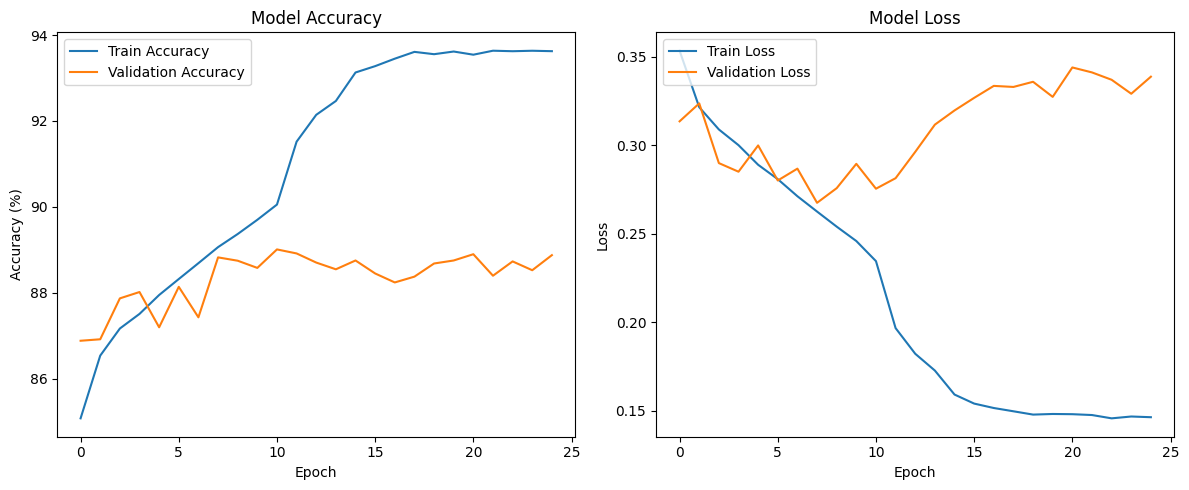

In [57]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


##  Final evaluation on test data

### Inference and Confusion Matrix


Final Accuracy of the model on the test set: 88.87%


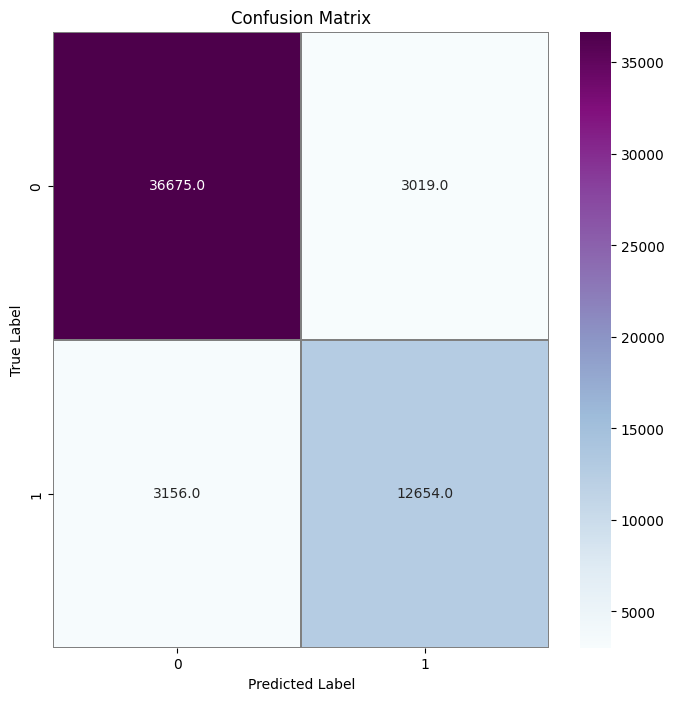

Predictions for the test set: [0 0 1 ... 0 0 1]


In [60]:
model.eval()


correct = 0
total = 0
all_preds = []
all_labels = []
predictions = []


with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        

        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate and print final accuracy
accuracy = 100 * correct / total
print(f"Final Accuracy of the model on the test set: {accuracy:.2f}%")

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt=".1f")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Convert predictions list to a NumPy array for further analysis if needed
predictions = np.array(predictions)

# Print predictions
print("Predictions for the test set:", predictions)


### Testing the Model

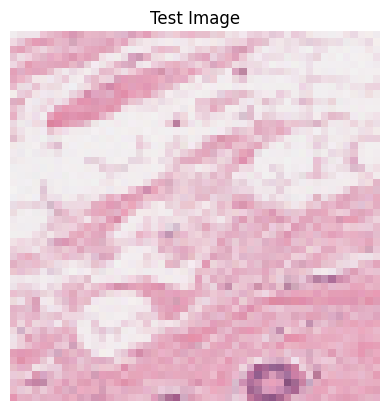

Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


In [61]:
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}


calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}


def plot_image(image_tensor):
    image = image_tensor.permute(1, 2, 0)  # Re-order dimensions for display
    image = image * 0.5 + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Test Image')
    plt.axis('off')
    plt.show()


data_iter = iter(test_loader)
images, labels = next(data_iter) 

# Select the first image in the batch for testing
image_to_test = images[0].unsqueeze(0) 
true_label = labels[0].item()

plot_image(images[0])

# Make prediction
model.eval()
with torch.no_grad():
    output = model(image_to_test)
    predicted_class_index = output.argmax(dim=1).item()

predicted_label = class_labels[predicted_class_index]
true_label_text = class_labels[true_label]

# Get calcification type based on the predicted class index
calcification_type = calcification_types.get(predicted_class_index, "Unknown")

print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label_text)




### Inference Function

In [84]:
def load_model(model_path='CNN_model.pth'):
    model = CNNModel()  
    model.load_state_dict(torch.load(model_path))
    model.eval()  
    return model



def infer_image(model,image_path):
    
    transform = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])
    
    # Load and preprocess the image
    image = PIL.Image.open(image_path).convert('RGB')  
    input_tensor = transform(image).unsqueeze(0)  
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)  
        print("Probabilities:", probabilities[0].cpu().numpy())

        predicted_class = output.argmax(dim=1).item()  # Get the predicted class index
        confidence = probabilities[0][predicted_class].item()  # Get the confidence for the predicted class

    # Get human-readable labels
    predicted_label = class_labels[predicted_class] 
    print(f'Predicted Diagnosis: {predicted_label}')
    print(f'Confidence: {confidence * 100:.2f}%')
    
    return predicted_label, confidence

# Usage Example
model = load_model('CNN_model.pth')
image_path = 'test_imgs/benign/ben1.jpg'   
predicted_label, confidence = infer_image(model,image_path)


Probabilities: [9.9999166e-01 8.3675259e-06]
Predicted Diagnosis: Non-Cancerous
Confidence: 100.00%


C:\Users\khale\AppData\Local\Temp\ipykernel_25932\1057250543.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

